<a href="https://colab.research.google.com/github/JRamos84/deteccion_fraude/blob/main/notebooks/04_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 04 Modeling
**Objetivo**: Construir y evaluar modelos de clasificación.
**Contenido**:

- Carga y preparación de los datos
- División de los datos en conjuntos de entrenamiento y prueba
- Entrenamiento de modelos
- Evaluación de los modelos
- Comparación de resultados

In [5]:
##  Importación de Librerías
import time
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, cv=5):
    # Asegúrate de que y_train y y_val sean vectores unidimensionales
    y_train = np.ravel(y_train)
    y_val = np.ravel(y_val)

    # Validación cruzada en el conjunto de entrenamiento
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)

    # Calcular métricas de validación cruzada
    accuracy_cv = cv_scores.mean()
    roc_auc_cv = roc_auc_score(y_train, y_train_pred_cv)

    # Imprimir métricas de validación cruzada
    print(f'Accuracy (CV): {accuracy_cv:.4f}')
    print(f'ROC AUC (CV): {roc_auc_cv:.4f}')
    print('Classification Report (CV):')
    print(classification_report(y_train, y_train_pred_cv))

    # Mostrar la matriz de confusión promediada
    conf_matrix_cv = confusion_matrix(y_train, y_train_pred_cv)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_cv, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (CV)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Entrenar el modelo con los datos de entrenamiento completos
    model.fit(X_train, y_train)

    # Predecir con los datos de validación
    y_val_pred = model.predict(X_val)

    # Calcular métricas en el conjunto de validación
    accuracy_val = accuracy_score(y_val, y_val_pred)
    roc_auc_val = roc_auc_score(y_val, y_val_pred)

    # Imprimir métricas del conjunto de validación
    print(f'Accuracy (Validation): {accuracy_val:.4f}')
    print(f'ROC AUC (Validation): {roc_auc_val:.4f}')
    print('Classification Report (Validation):')
    print(classification_report(y_val, y_val_pred))

    # Mostrar la matriz de confusión del conjunto de validación
    conf_matrix_val = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Retornar el modelo entrenado
    return model


def train_xgboost_model(X_train, y_train, X_val, y_val, params, num_rounds=100, threshold=0.5):
    # Convertir datos a DMatrix (formato optimizado para XGBoost)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Entrenar el modelo
    model = xgb.train(params, dtrain, num_rounds)

    # Predecir probabilidades en el conjunto de validación
    y_pred_proba = model.predict(dval)

    # Convertir probabilidades a etiquetas binarias
    y_pred_binary = [1 if p > threshold else 0 for p in y_pred_proba]

    # Calcular la precisión en el conjunto de validación
    accuracy = accuracy_score(y_val, y_pred_binary)
    print(f'Precisión en el conjunto de validación (Accuracy): {accuracy:.2f}')

    # Calcular el área bajo la curva ROC (ROC AUC)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    print(f'Área bajo la curva ROC (ROC AUC): {roc_auc:.2f}')

    # Imprimir el reporte de clasificación en el conjunto de validación
    print('Classification Report (Validation):')
    print(classification_report(y_val, y_pred_binary))

    # Mostrar la matriz de confusión en el conjunto de validación
    conf_matrix = confusion_matrix(y_val, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()




In [7]:
## Importamos las librerias a usar
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Carga y Preparación de los Datos

- Se exportaron los datos de entrenamiento y validación procesados en la sección 02_Data_Cleaning_and_Preprocessing.

In [8]:
#

#dir_data_processed = '../data/processed'
dir_data_processed = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/processed'
ruta_archivo_X_train = os.path.join(dir_data_processed, 'X__train_procesados.csv')
ruta_archivo_X_val = os.path.join(dir_data_processed, 'X_val_procesados.csv')

ruta_archivo_y_train = os.path.join(dir_data_processed, 'y_train_procesados.csv')
ruta_archivo_y_val = os.path.join(dir_data_processed, 'y_val_procesados.csv')
X_train_final= pd.read_csv(ruta_archivo_X_train)
X_val_final= pd.read_csv(ruta_archivo_X_val)
y_train_final= pd.read_csv(ruta_archivo_y_train)
y_val_final= pd.read_csv(ruta_archivo_y_val)

In [9]:
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

print(y_train_final.shape)
print(y_val_final.shape)
print(y_test_final.shape)

(242811, 184)
(52031, 184)
(52032, 184)
(242811, 1)
(52031, 1)
(52032, 1)


### Recuperación de lista de nombres de columnas por *Feature Selection*

In [10]:
dir_data_processed = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/processed'
ruta_archivo_columns = os.path.join(dir_data_processed, 'columns_feature_selection.pkl')
with open(ruta_archivo_columns, 'rb') as file:
    cat_cols_selected , col_selected_num = pickle.load(file)

print('num_cols_feature_selection:', col_selected_num )
print('cat_cols_feature_selection:', cat_cols_selected )


num_cols_feature_selection: ['V283', 'V281', 'V280', 'V282', 'V279', 'V295', 'V308', 'V293', 'V312', 'V307', 'V95', 'V292', 'V97', 'V315', 'V318', 'V289', 'V317', 'V128', 'V101', 'V103', 'V62', 'V291', 'V294', 'V313', 'V314', 'V56', 'V288', 'V29', 'V131', 'V90', 'V69', 'V284', 'V30', 'V127', 'V91', 'V74', 'V70', 'V134', 'V290', 'V133', 'V287', 'V67', 'V33', 'V34', 'V94', 'V309', 'V98', 'V310', 'V102', 'V306', 'V73', 'V78', 'V83', 'V100', 'V55', 'V316', 'TransactionAmt', 'V96', 'V20', 'V126', 'V296', 'V298', 'V61', 'V130', 'V129', 'V54', 'V132']
cat_cols_feature_selection: ['card6', '_Days', '_Hours']


In [11]:
len(col_selected_num) + len(cat_cols_selected)

70

### Balanceo de muestra

In [12]:
## Balanceo de X_train y y_train totales
undersampler = RandomUnderSampler(random_state=42)
X_train_B, y_train_B,= undersampler.fit_resample(X_train_final, y_train_final)
# Mostrar la distribución de clases después del submuestreo
X_train_B.shape, y_train_B.shape

((9716, 184), (9716, 1))

In [13]:
unique, counts = np.unique(y_train_B, return_counts=True)

# Crear un diccionario para mostrar los resultados
value_counts = dict(zip(unique, counts))
print(value_counts)

{0: 4858, 1: 4858}


In [14]:
dir_data_preprocessing='/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/preprocessing_objects'
pca = joblib.load(os.path.join(dir_data_preprocessing, 'pca.joblib'))
X_train_pca_B = pca.transform(X_train_B)
X_val_pca_B = pca.transform(X_val_final)

### Comparación de modelos de entrenamiento

In [15]:

# Definir los modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Evaluar cada modelo con validación cruzada
for name, model in models.items():
    # Calcular Accuracy
    start_time = time.time()
    accuracy_scores = cross_val_score(model, X_train_pca_B, np.ravel(y_train_B), cv=5, scoring='accuracy')

    # Calcular ROC AUC
    roc_auc_scores = cross_val_score(model, X_train_pca_B, np.ravel(y_train_B), cv=5, scoring='roc_auc')

    # Imprimir resultados
    print(f"{name}:")
    print(f"  Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
    print(f"  ROC AUC: {roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"El tiempo de entrenamiento fue de {elapsed_time:.2f} segundos")


Logistic Regression:
  Accuracy: 0.7176 ± 0.0088
  ROC AUC: 0.7929 ± 0.0070
El tiempo de entrenamiento fue de 8.61 segundos
Random Forest:
  Accuracy: 0.7913 ± 0.0081
  ROC AUC: 0.8722 ± 0.0070
El tiempo de entrenamiento fue de 71.83 segundos
KNN:
  Accuracy: 0.5920 ± 0.0100
  ROC AUC: 0.6205 ± 0.0101
El tiempo de entrenamiento fue de 3.13 segundos
Naive Bayes:
  Accuracy: 0.6639 ± 0.0101
  ROC AUC: 0.7446 ± 0.0090
El tiempo de entrenamiento fue de 0.15 segundos


- El modelo con las mejores métricas es Random Forest, pero su tiempo de entrenamiento es significativamente mayor que el de los demás modelos. Es importante tener en cuenta este factor.

### Entrenamiento con Random Forest

#### Con datos balanceados

Accuracy (CV): 0.7845
ROC AUC (CV): 0.7845
Classification Report (CV):
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      4858
           1       0.79      0.78      0.78      4858

    accuracy                           0.78      9716
   macro avg       0.78      0.78      0.78      9716
weighted avg       0.78      0.78      0.78      9716



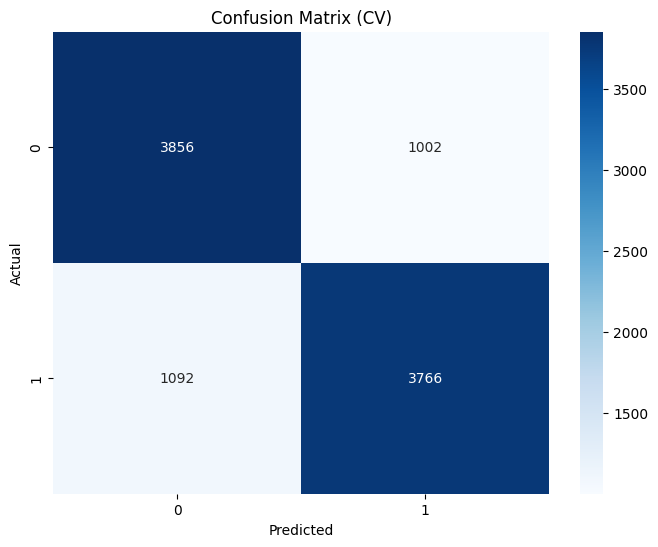

Accuracy (Validation): 0.8027
ROC AUC (Validation): 0.7850
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.80      0.89     50990
           1       0.07      0.77      0.13      1041

    accuracy                           0.80     52031
   macro avg       0.53      0.78      0.51     52031
weighted avg       0.98      0.80      0.87     52031



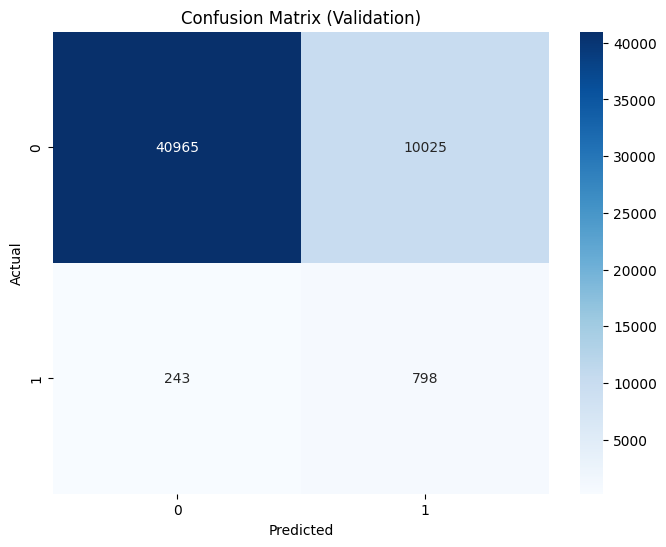

In [16]:
rf_clf = train_and_evaluate_model(RandomForestClassifier(random_state=42), X_train_B, y_train_B, X_val_final, y_val_final)

<ipython-input-17-3ac8a6bee0e4>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(40), palette='viridis')


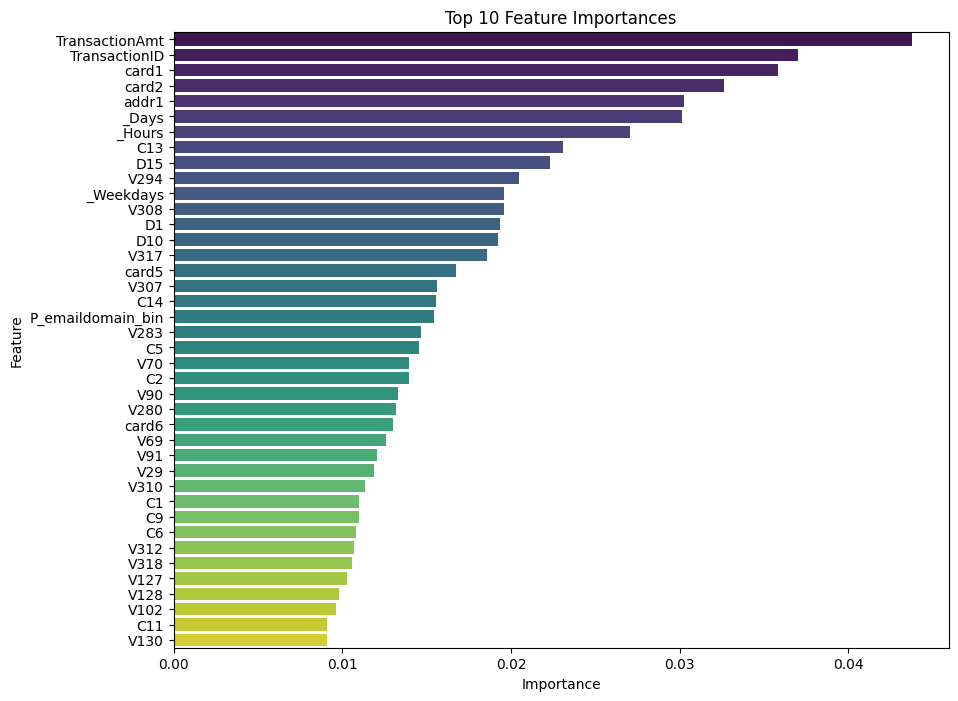

In [17]:

feature_importance = rf_clf.feature_importances_

# Obtener nombres de las características
feature_names = X_train_final.columns

# Crear un DataFrame para visualización
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordenar por importancia de forma descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar las 10 características más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(40), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.show()

#### Con datos Balanceados con PCA

Accuracy (CV): 0.7913
ROC AUC (CV): 0.7913
Classification Report (CV):
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      4858
           1       0.79      0.79      0.79      4858

    accuracy                           0.79      9716
   macro avg       0.79      0.79      0.79      9716
weighted avg       0.79      0.79      0.79      9716



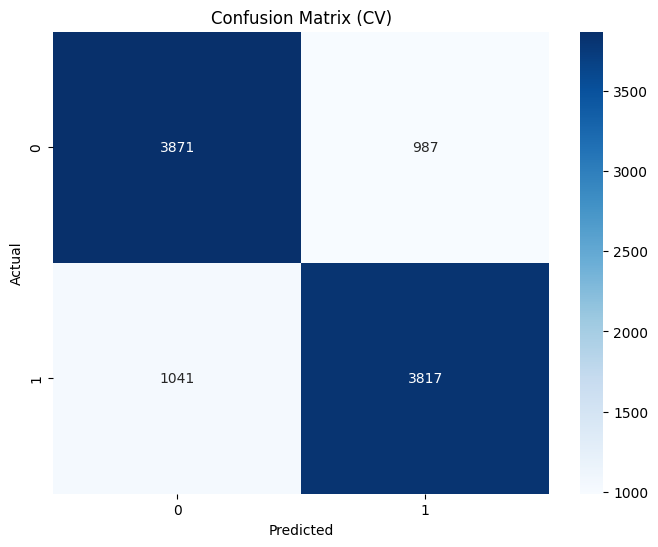

Accuracy (Validation): 0.8159
ROC AUC (Validation): 0.7955
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     50990
           1       0.08      0.77      0.14      1041

    accuracy                           0.82     52031
   macro avg       0.54      0.80      0.52     52031
weighted avg       0.98      0.82      0.88     52031



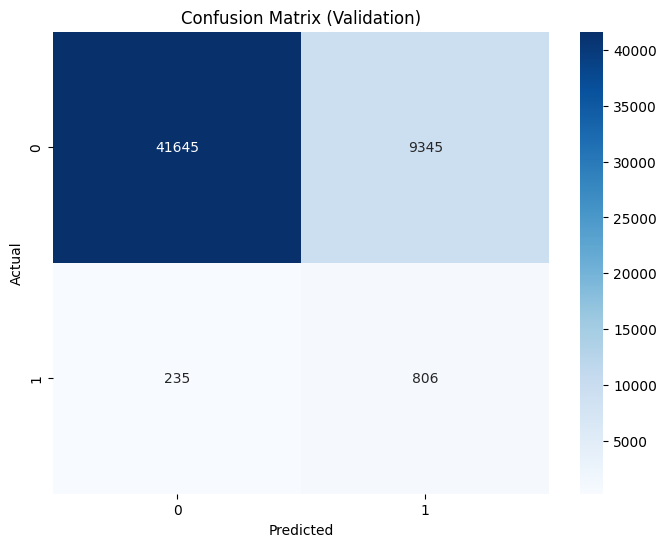

In [18]:
rf_clf_PCA = train_and_evaluate_model(RandomForestClassifier(random_state=42), X_train_pca_B, y_train_B, X_val_pca_B, y_val_final)

<ipython-input-19-62dd7dbb4266>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=original_feature_importance_df.head(26), palette='viridis')


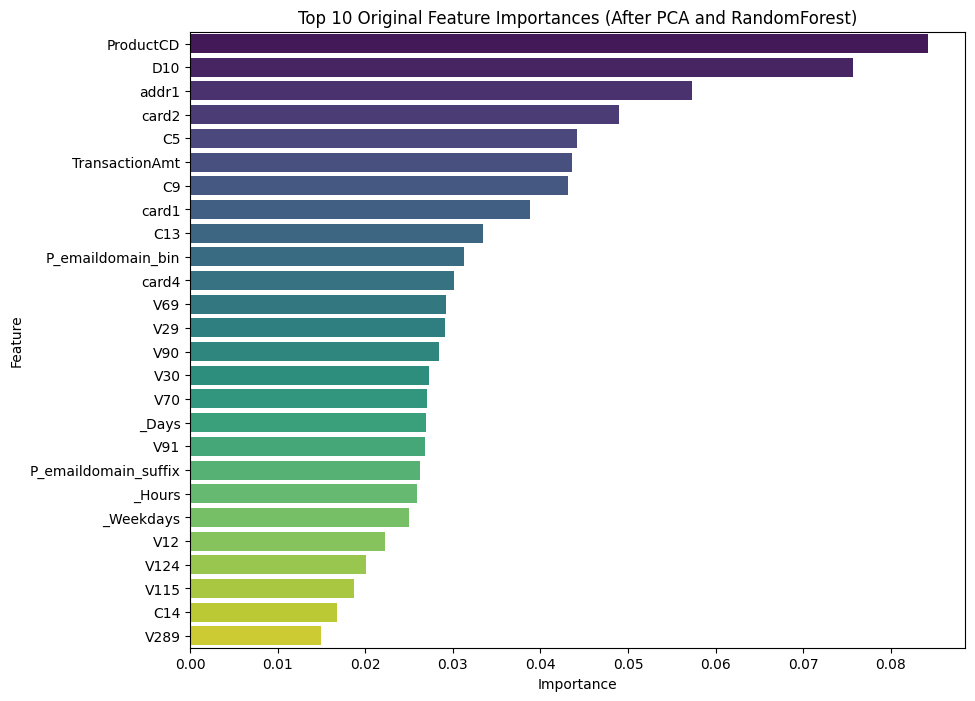

In [19]:

# Obtener las importancias de las componentes principales del modelo RandomForest
feature_importance_pca = rf_clf_PCA.feature_importances_

# Obtener las cargas de las características originales en las componentes principales
components = pca.components_

# Crear un DataFrame para visualización de las cargas de las características originales en las componentes principales
component_names = [f"PC{i+1}" for i in range(components.shape[0])]
feature_names = X_train_final.columns
component_df = pd.DataFrame(components, columns=feature_names, index=component_names)

# Calcular la importancia relativa de las características originales
original_feature_importance = np.abs(component_df.T @ feature_importance_pca)

# Crear un DataFrame para visualización de la importancia relativa de las características originales
original_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': original_feature_importance})
original_feature_importance_df = original_feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar las 10 características originales más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=original_feature_importance_df.head(26), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Original Feature Importances (After PCA and RandomForest)')
plt.show()


#### Utilizando *Feature Selection* en el en entrenamiento

In [21]:
len(col_selected_num) + len(cat_cols_selected)

70

Accuracy (CV): 0.7417
ROC AUC (CV): 0.7417
Classification Report (CV):
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      4858
           1       0.74      0.74      0.74      4858

    accuracy                           0.74      9716
   macro avg       0.74      0.74      0.74      9716
weighted avg       0.74      0.74      0.74      9716



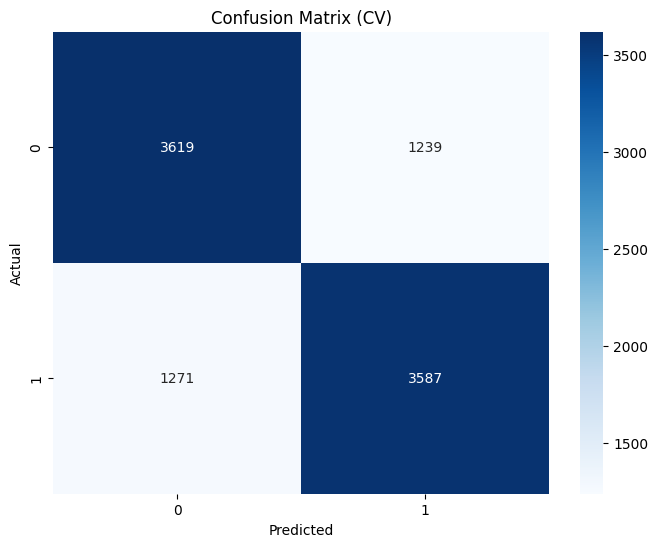

Accuracy (Validation): 0.7510
ROC AUC (Validation): 0.7417
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.75      0.86     50990
           1       0.06      0.73      0.11      1041

    accuracy                           0.75     52031
   macro avg       0.52      0.74      0.48     52031
weighted avg       0.97      0.75      0.84     52031



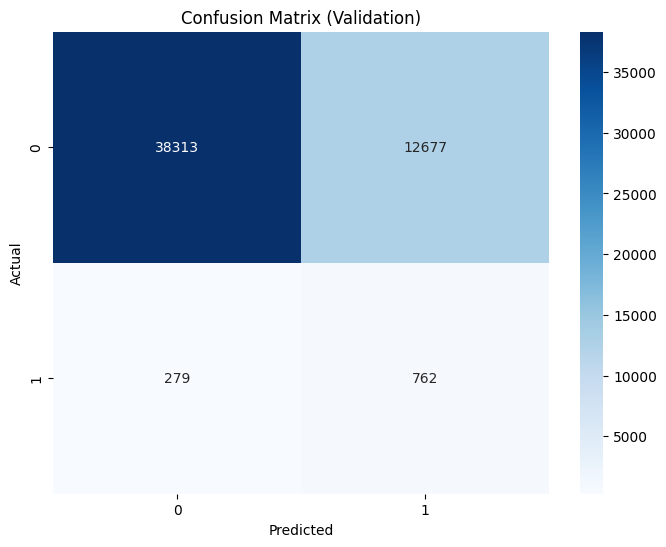

In [22]:
X_train_selection = X_train_B[col_selected_num + cat_cols_selected]
X_val_selection = X_val_final[col_selected_num + cat_cols_selected]
rf_clf_selection = train_and_evaluate_model(RandomForestClassifier(random_state=42), X_train_selection, y_train_B, X_val_selection, y_val_final)

<ipython-input-23-77f8bb4e8367>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(40), palette='viridis')


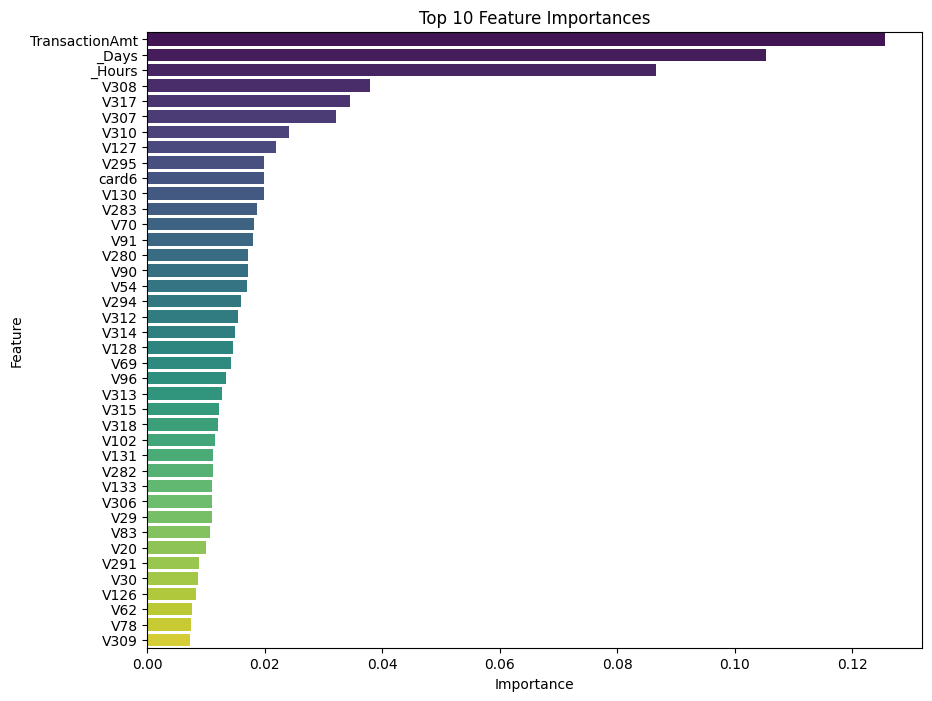

In [23]:

feature_importance = rf_clf_selection .feature_importances_

# Obtener nombres de las características
feature_names = X_train_selection.columns

# Crear un DataFrame para visualización
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordenar por importancia de forma descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar las 10 características más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(40), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.show()

### Entrenamiento Con Xbgboost

Precisión en el conjunto de validación (Accuracy): 0.75
Área bajo la curva ROC (ROC AUC): 0.76
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.75      0.86     50990
           1       0.05      0.64      0.09      1041

    accuracy                           0.75     52031
   macro avg       0.52      0.70      0.47     52031
weighted avg       0.97      0.75      0.84     52031



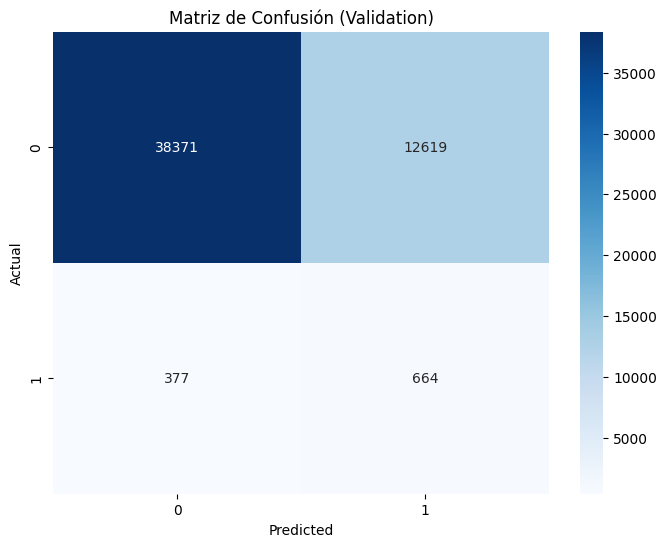

In [20]:

params = {
    'eta': 0.0001,
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc']
}
train_xgboost_model(X_train_pca_B, y_train_B, X_val_pca_B, y_val_final, params)

Se puede observar que el rendimiento varía según el rango de TransactionAmt tanto para los modelos de Random Forest como para XGBoost.

## Conclusión


- Se evaluaron varios modelos de clasificación binaria utilizando parámetros por defecto, y el modelo que destacó fue el Random Forest, seleccionado basándose en los resultados de validación cruzada.

- El modelo Random Forest se evaluó con las siguientes configuraciones:

  - Utilizando todas las columnas con datos balanceados.
  - Aplicando balanceo de datos y reducción de dimensiones mediante PCA.
  - Empleando reducción de columnas mediante selección de características.
Los resultados se muestran a continuación:

1. **Con datos balanceados:**
   - Accuracy (CV): 0.7845
   - ROC AUC (CV): 0.7845
   - Classification Report (CV):
     ```
                  precision    recall  f1-score   support

               0       0.78      0.79      0.79      4858
               1       0.79      0.78      0.78      4858

        accuracy                           0.78      9716
       macro avg       0.78      0.78      0.78      9716
    weighted avg       0.78      0.78      0.78      9716
     ```

2. **Con datos balanceados y PCA:**
   - Accuracy (Validation): 0.8159
   - ROC AUC (Validation): 0.7955
   - Classification Report (Validation):
     ```
                  precision    recall  f1-score   support

               0       0.99      0.82      0.90     50990
               1       0.08      0.77      0.14      1041

        accuracy                           0.82     52031
       macro avg       0.54      0.80      0.52     52031
    weighted avg       0.98      0.82      0.88     52031
     ```

3. **Utilizando Feature Selection en el entrenamiento:**
   - Accuracy (Validation): 0.7510
   - ROC AUC (Validation): 0.7417
   - Classification Report (Validation):
     ```
                  precision    recall  f1-score   support

               0       0.99      0.75      0.86     50990
               1       0.06      0.73      0.11      1041

        accuracy                           0.75     52031
       macro avg       0.52      0.74      0.48     52031
    weighted avg       0.97      0.75      0.84     52031
     ```

Todos los enfoques mostraron resultados diferentes en las métricas de evaluación. La configuración con datos balanceados y reducción de columnas mediante PCA obtuvo el mejor desempeño en términos de precisión y ROC AUC, mostrando una mejora significativa en la predicción de la clase minoritaria (1). Esto indica que la combinación de balanceo de datos y reducción de dimensionalidad puede mejorar la capacidad del modelo para detectar casos positivos de manera efectiva.

En contraste, el enfoque utilizando Feature Selection mostró un desempeño inferior en términos de precisión y ROC AUC, lo que sugiere que la selección de características por sí sola puede no ser tan efectiva en este escenario específico.

Por lo tanto, se recomienda utilizar el modelo entrenado con datos balanceados y reducción de columnas mediante PCA para futuras predicciones, dado su mejor rendimiento general en la validación.
 - Además, se extrajeron las características más importantes para cada tipo de datos de entrenamiento, proporcionando insights adicionales sobre los factores que más influyen en las predicciones del modelo.


